# Report 3

### by Kaitlyn Keil and Kevin Zhang
### April 2017

<a href = http://tna.europarchive.org/20110116113217/http:/www.food.gov.uk/science/dietarysurveys/dietsurveys/>UK Nutrient Databank</a>

<a href = http://tna.europarchive.org/20110116113217/http://www.food.gov.uk/multimedia/pdfs/cofuserdoc.pdf>User Documentation</a>

In [1]:
""" This file contains code used to analyze the
UK Food Nutrient Databank, the information for which can be found
at the above links.

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
%matplotlib inline
import seaborn as sns

from collections import defaultdict, Counter
import statsmodels.formula.api as smf

In [2]:
def ReadProximates():
    """ Reads the correct sheet from the Excel Spreadsheet downloaded from the databank.
    Cleans the macronutrient data and replaces non-numerical entries with 0.
    
    Returns: cleaned DataFrame
    """
    df = pd.read_excel('dietary.xls', sheetname='Proximates')
    column_list = ['Water (g)', 'Protein (g)', 'Fat (g)', 'Carbohydrate (g)', 'Total sugars (g)']
    
    df['Water'] = pd.to_numeric(df['Water (g)'], errors='coerce')
    df['Protein'] = pd.to_numeric(df['Protein (g)'], errors='coerce')
    df['Fat'] = pd.to_numeric(df['Fat (g)'], errors='coerce')
    df['Carbohydrate'] = pd.to_numeric(df['Carbohydrate (g)'], errors='coerce')
    df['Sugars'] = pd.to_numeric(df['Total sugars (g)'], errors='coerce')
    
    df['Water'].replace([np.nan], 0, inplace=True)
    df['Protein'].replace([np.nan], 0, inplace=True)
    df['Fat'].replace([np.nan], 0, inplace=True)
    df['Carbohydrate'].replace([np.nan], 0, inplace=True)
    df['Sugars'].replace([np.nan], 0, inplace=True)
        
    return df

In [3]:
tester = ReadProximates()

In [4]:
# Plot clusters on a 2D log scale for first-glance. They do not appear to be particularly differentiated.
# Log coordinates are better for visualization in this instance.

x_vals = 'Protein'
y_vals = 'Carbohydrate'
z_vals = 'Fat'

food_group_dict = {'A':['Cereals','peru'], 'B':['Dairy','beige'], 'C':['Egg','paleturquoise'],
                  'D':['Vegetable','darkolivegreen'], 'F':['Fruit','firebrick'], 'G':['Nuts','saddlebrown'],
                  'J':['Fish','slategray'],'M':['Meat','indianred'], 'O':['Fat','khaki']}

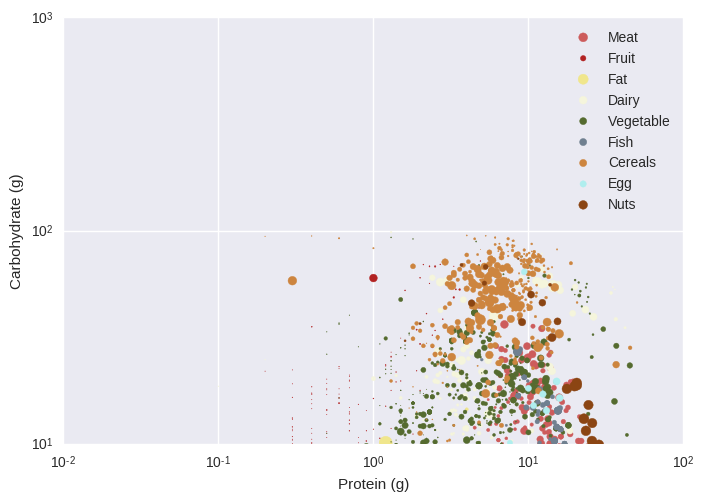

In [5]:
ax = plt.subplot(111)
for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter(df[x_vals],df[y_vals],df[z_vals],color=val[1],label = val[0])
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel(x_vals+' (g)')  
ax.set_ylabel(y_vals+' (g)')
ax.legend()

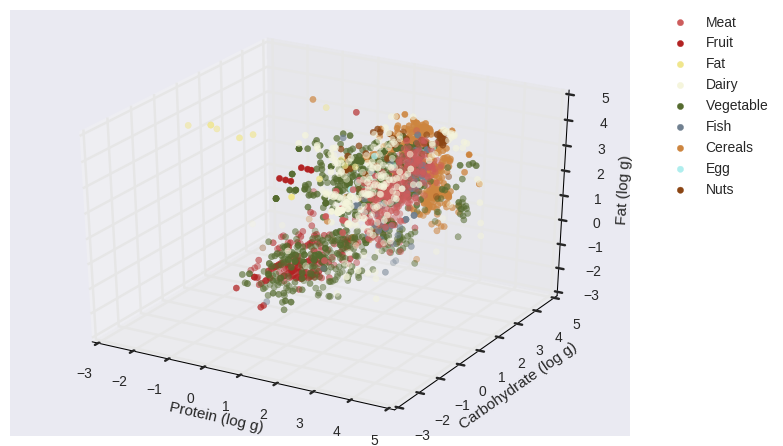

In [6]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
#ax.scatter3D(tester[x_vals], tester[y_vals], tester[z_vals])

for key,val in food_group_dict.items():
    df = tester[tester.Group.str.startswith(key, na=False)]
    ax.scatter3D(np.log(df[x_vals]),np.log(df[y_vals]),np.log(df[z_vals]),color=val[1],label = val[0])
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(x_vals+' (log g)')  
ax.set_ylabel(y_vals+' (log g)')
ax.set_zlabel(z_vals+' (log g)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [7]:
def ThreeDPlot(pred_cat, actual_cat, ax, actual_label, colors = ['firebrick', 'peru']):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax.scatter3D(np.log(pred_cat.Protein),np.log(pred_cat.Carbs), np.log(pred_cat.Fat), c = colors[0], label = 'Predicted Group')
    ax.scatter3D(np.log(actual_cat.Protein),np.log(actual_cat.Carbohydrate), np.log(actual_cat.Fat), c = colors[1], label = actual_label, alpha= .5)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

In [8]:
#  Create the categories for the different food pyramid groups.
#   Labels were assigned by attempting to find the best match
#   with the generated groups.

cereals = tester[tester.Group.str.startswith('A', na=False)]
cereals['Label'] = cereals.Water*0+3

fruits = tester[tester.Group.str.startswith('F', na=False)]
fruits['Label'] = fruits.Water*0+4

veggies = tester[tester.Group.str.startswith('D', na=False)]
veggies['Label'] = veggies.Water*0+0

dairy = tester[tester.Group.str.startswith('B', na=False)]
dairy['Label'] = dairy.Water*0+2

oils = tester[tester.Group.str.startswith('O', na=False)]
oils['Label'] = oils.Water*0+5

m1 = tester[tester.Group.str.startswith('J', na=False)]
m2 = tester[tester.Group.str.startswith('M', na=False)]
meats = pd.concat([m1,m2])
meats['Label'] = meats.Water*0+1

# Create a dataframe using only these categories (drops nuts, eggs, soups/misc, etc)
all_these = pd.concat([cereals, fruits, veggies, dairy, oils, meats])


/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kaitlyn/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [9]:
from sklearn.cluster import KMeans

# Selects the appropriate macronutrient columns to feed to the kmeans algorithm
water = pd.Series(all_these.Water, name='Water')
protein = pd.Series(all_these.Protein, name='Protein')
fat = pd.Series(all_these.Fat, name='Fat')
carbs = pd.Series(all_these.Carbohydrate, name='Carbs')
sugars = pd.Series(all_these['Sugars'], name='Sugars')

# Create a new DataFrame using only the macronutrient columns
X = pd.concat([water, protein,fat,carbs,sugars], axis=1)
X.fillna(0)
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X.dropna())
y_kmeans = kmeans.predict(X)

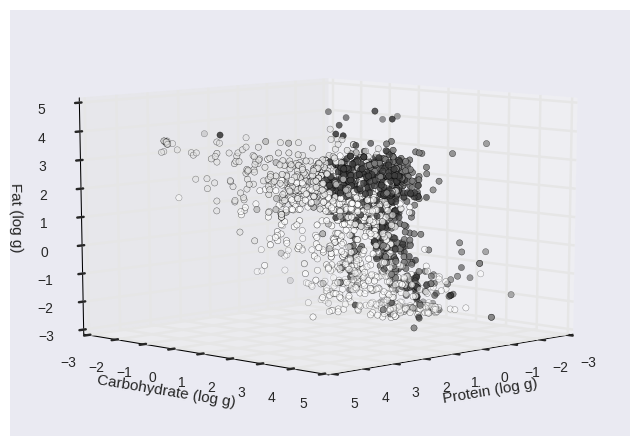

In [10]:
# Created clusters from the kmeans algorithm

ax = plt.subplot(projection='3d')

ax.scatter3D(np.log(X.Protein),np.log(X.Carbs), np.log(X.Fat), c = y_kmeans)
ax.view_init(elev=10, azim=45)
    
ax.set_xlabel('Protein (log g)')
ax.set_ylabel('Carbohydrate (log g)')
ax.set_zlabel('Fat (log g)')

In [11]:
# Create a way to select the categories

predicted_labels = pd.DataFrame(y_kmeans, index=X.index).astype(float)
X['predictions'] = predicted_labels

In [12]:
# Separate out the categories for individual analysis

labeled0 = X[X.predictions == 0]
labeled1 = X[X.predictions == 1]
labeled2 = X[X.predictions == 2]
labeled3 = X[X.predictions == 3]
labeled4 = X[X.predictions == 4]
labeled5 = X[X.predictions == 5]

Following are two examples, plotted on the 3d log scale. For the rest of the comparisons, see the bottom of the journal.

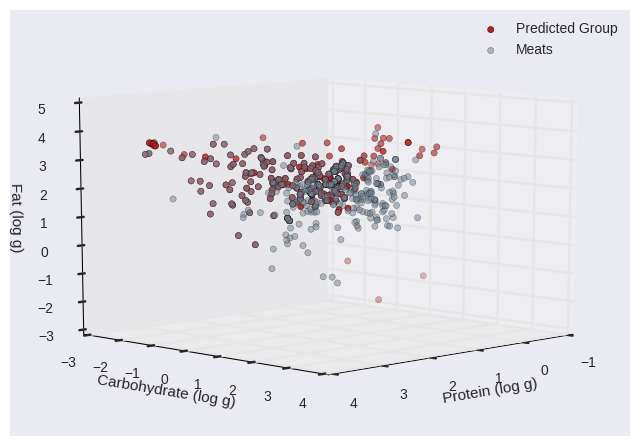

In [13]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled1, meats, ax, 'Meats', ['firebrick','slategray'])

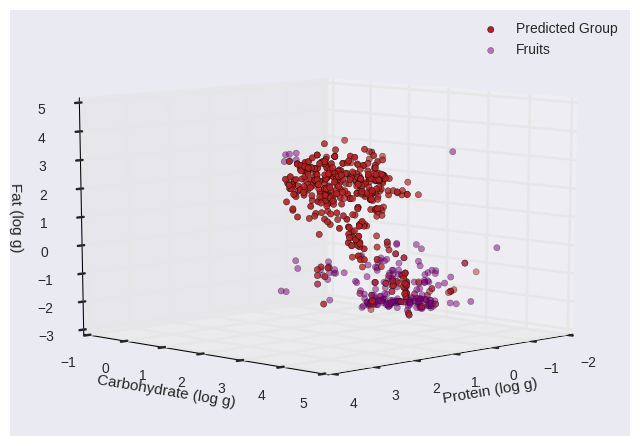

In [14]:
ax = plt.subplot(projection='3d')
ThreeDPlot(labeled4, fruits, ax, 'Fruits', ['firebrick','purple'])

In [15]:
# Use this to generate an accuracy score. Ours was 53%

from sklearn.metrics import accuracy_score

accuracy_score(all_these.Label,predicted_labels)

0.532258064516129

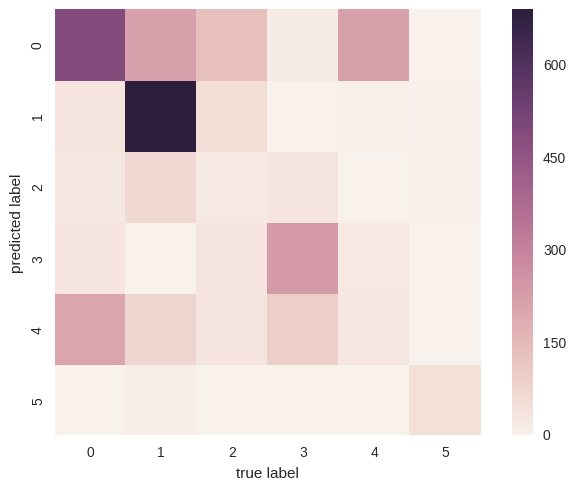

In [16]:
# Look at confusion matrix for some idea of accuracy. Meats has the highest rate of matching.

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(all_these.Label, predicted_labels)
sns.heatmap(mat.T, square=True)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Veggies are 0
# Meats are 1
# Dairy is 2
# Cereals are 3
# Fruits are 4
# Oils are 5

In [17]:
all_these['guess'] = predicted_labels[0]
all_these['correct_guess'] = np.where((all_these.Label == all_these.guess), True, False)

In [40]:
def HowMatched3D(df, label_int, actual_label):
    """ Creates a 3D log log plot on the requested subplot.
    Arguments: 
    pred_cat = predicted dataframe for a category
    actual_cat = dataframe of the real category
    ax = plt axis instance
    actual_label = string with label for the actual category
    colors = list with two entries of strings for color names
    """
    ax = plt.subplot(projection='3d')
    TP = df[(df.Label == label_int)&(df.correct_guess==True)]
    FP = df[(df.guess == label_int)&(df.correct_guess==False)]
    FN = df[(df.Label == label_int)&(df.correct_guess==False)]
    print('Matches:',len(TP), 'In Group, is not '+actual_label+':',len(FP), 'Not in Group, is '+actual_label+':',len(FN))
    ax.scatter3D(np.log(TP.Protein),np.log(TP.Carbohydrate), np.log(TP.Fat), c = 'purple', label = 'In Group, is '+actual_label)
    ax.scatter3D(np.log(FP.Protein),np.log(FP.Carbohydrate), np.log(FP.Fat), c = 'crimson', label = 'In Group, is not '+actual_label)
    ax.scatter3D(np.log(FN.Protein),np.log(FN.Carbohydrate), np.log(FN.Fat), c = 'darkgreen', label = 'Not in Group, is '+actual_label)
    ax.view_init(elev=10, azim=45)
    
    ax.set_xlabel('Protein (log g)')
    ax.set_ylabel('Carbohydrate (log g)')
    ax.set_zlabel('Fat (log g)')
    plt.legend()

Matches: 489 In Group, is not Vegetable: 587 Not in Group, is Vegetable: 297


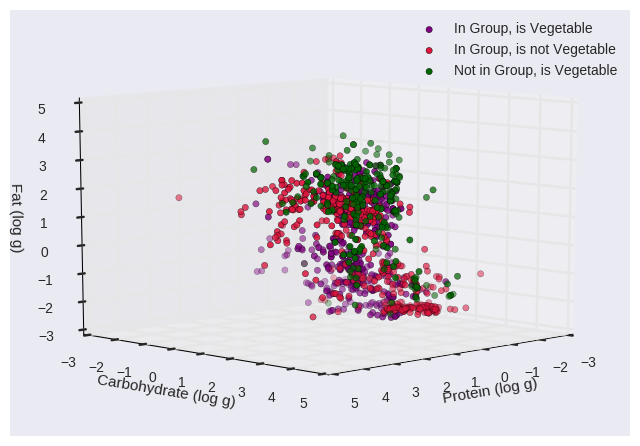

In [41]:
HowMatched3D(all_these, 0, 'Vegetable')

Matches: 691 In Group, is not Meat: 97 Not in Group, is Meat: 376


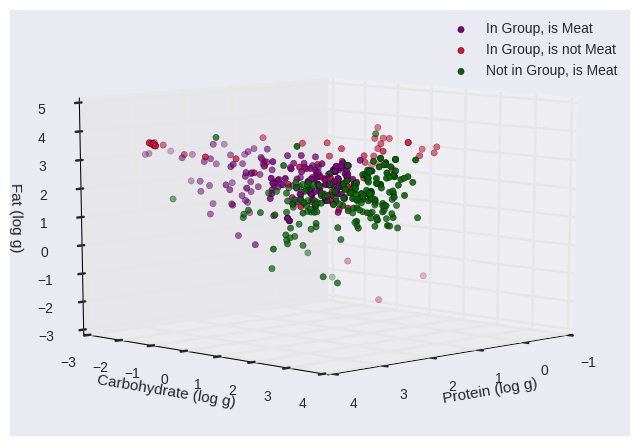

In [42]:
HowMatched3D(all_these, 1, 'Meat')

Matches: 23 In Group, is not Dairy: 131 Not in Group, is Dairy: 260


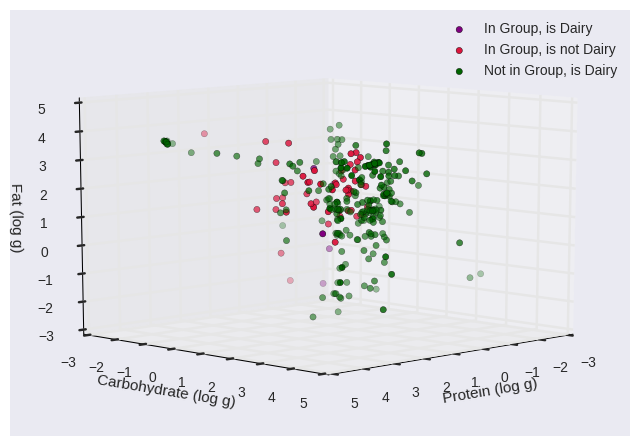

In [43]:
HowMatched3D(all_these, 2, 'Dairy')

Matches: 237 In Group, is not Cereal: 90 Not in Group, is Cereal: 146


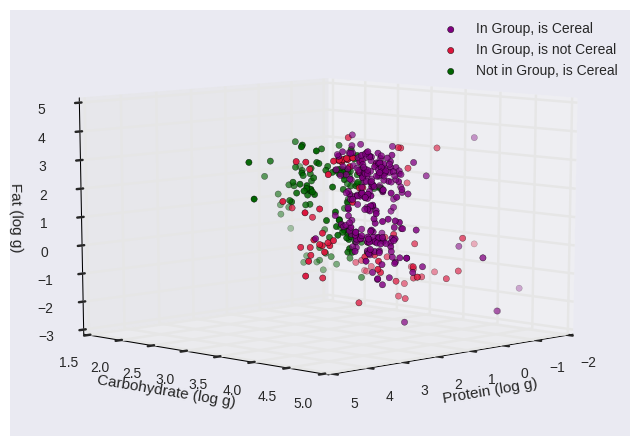

In [44]:
HowMatched3D(all_these, 3, 'Cereal')

Matches: 32 In Group, is not Fruit: 414 Not in Group, is Fruit: 248


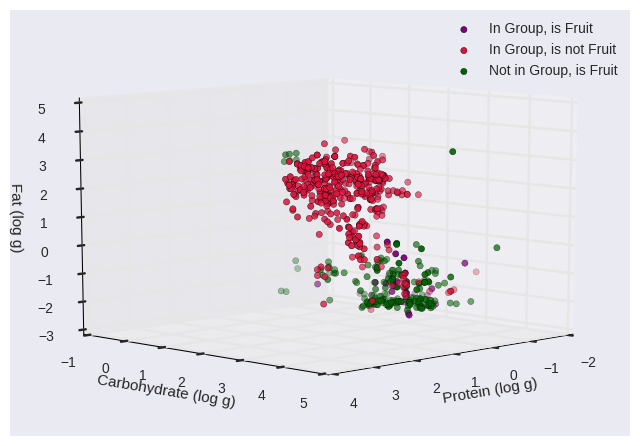

In [45]:
HowMatched3D(all_these, 4, 'Fruit')

Matches: 46 In Group, is not Oil: 15 Not in Group, is Oil: 7


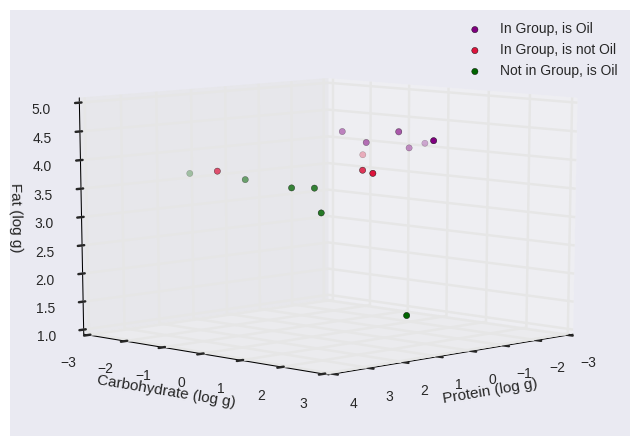

In [46]:
HowMatched3D(all_these, 5, 'Oil')

In [18]:
# 1518 correct guesses, some examples of which follow
guessed_correctly = all_these[all_these.correct_guess == True]
print(guessed_correctly['Food Name'])

140                 Biscuits, homemade, rubbing-in method
141                                            Shortbread
142                         Crunch biscuits, cream filled
143                                   Semi-sweet biscuits
144                       Sandwich biscuits, cream filled
145                                    Oatcakes, homemade
146                                  Short sweet biscuits
147                                      Oatcakes, retail
148                                Wafer biscuits, filled
149                                             Flapjacks
150                                    Wholemeal crackers
151                          Gingernut biscuits, homemade
152                   Biscuits, homemade, creaming method
153                         Biscuits, homemade, wholemeal
154                   Biscuits, melting moments, homemade
155                                    Oat based biscuits
156         Chocolate biscuits, cream filled, full coated
157           

In [116]:
# 1334 incorrect guesses. Some examples follow.

guessed_wrong = all_these[all_these.correct_guess==False]
print(guessed_wrong['Food Name'])

158                                        Cornish wafers
162                              Cheese sandwich biscuits
163                                             Fig rolls
164                                        Fruit biscuits
165                                          Krackerwheat
166            Oat based biscuits, chocolate, half coated
173                     Shortcake, chocolate, half coated
177                       White bread, 'with added fibre'
179     White bread, farmhouse or split tin, freshly b...
181                                   White bread, sliced
182                             White bread, Danish style
184                                  White bread, premium
186                                       Wheatgerm bread
188                              Wholemeal bread, average
195                                   Pappadums, takeaway
197                                               Paratha
201                                             Rye bread
203           

Beyond this point are pairs of 3D cluster plots, to compare each generated group with the food pyramid groups.

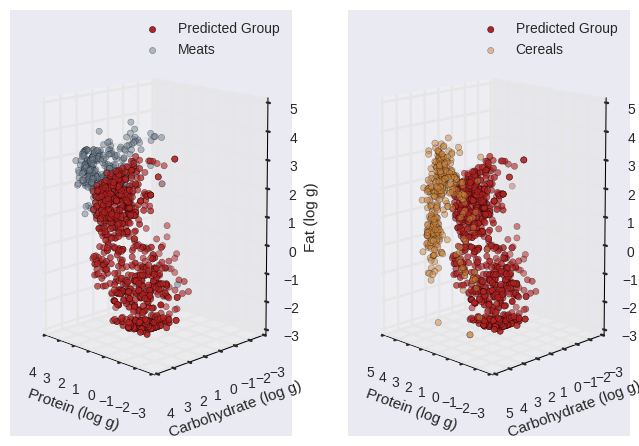

In [95]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

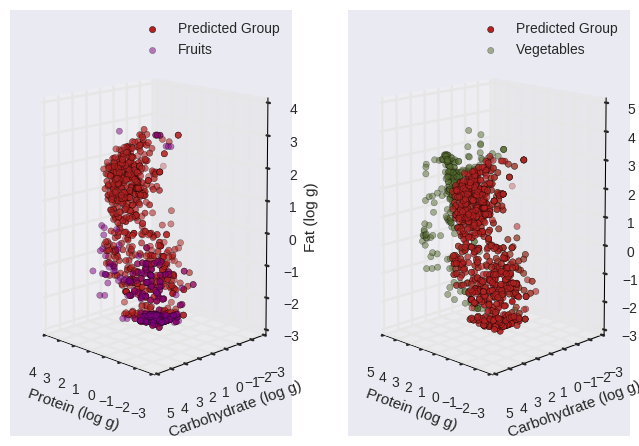

In [96]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

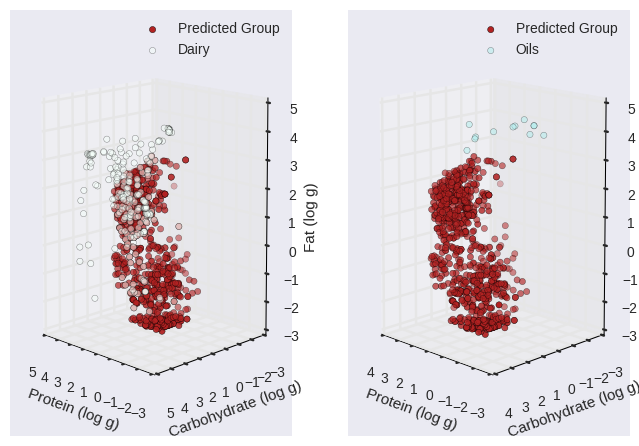

In [97]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled0, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled0, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

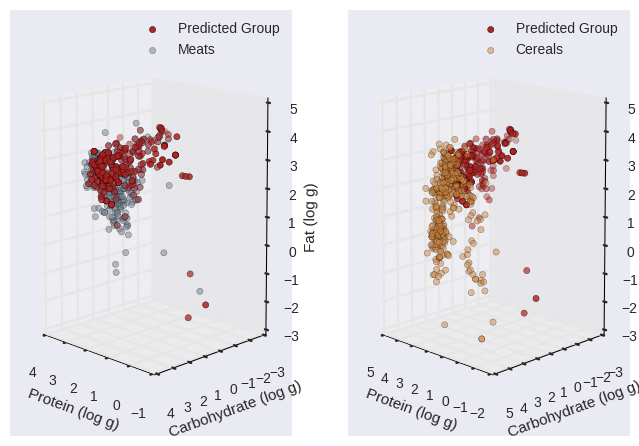

In [98]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

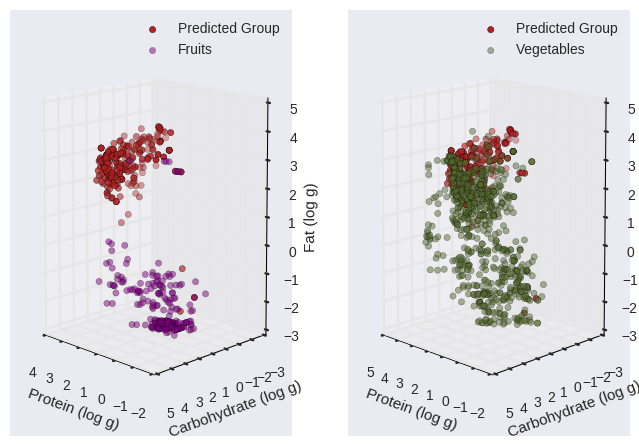

In [99]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

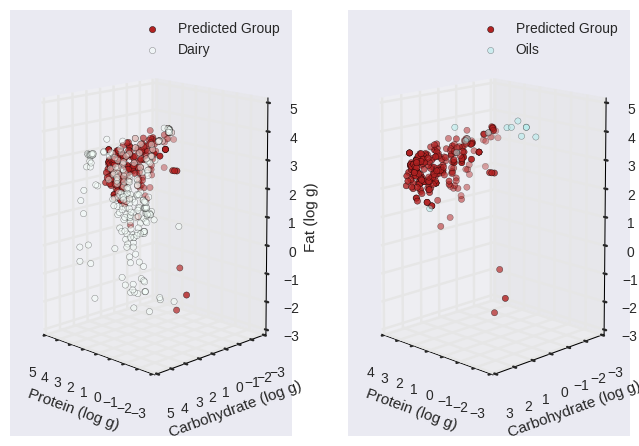

In [100]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled1, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled1, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

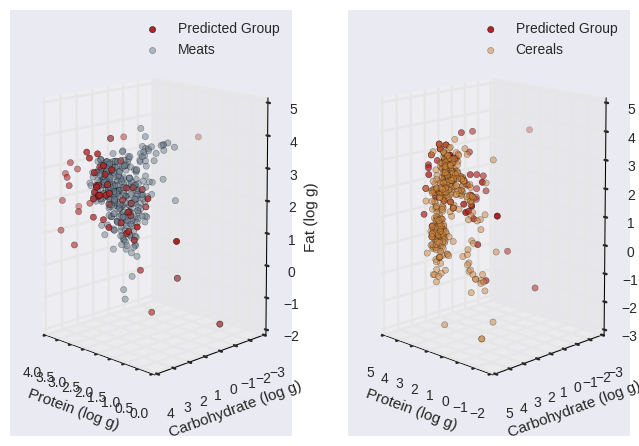

In [101]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

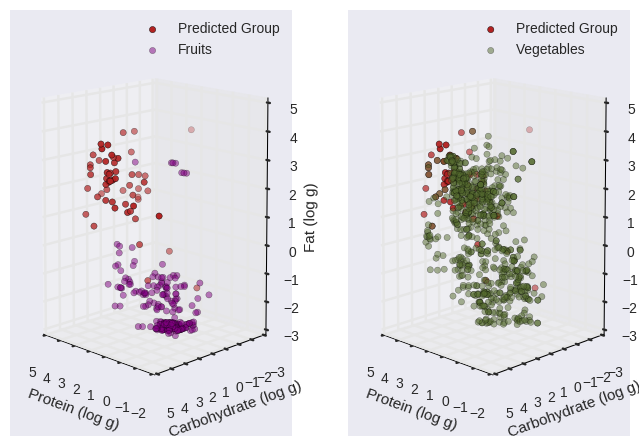

In [102]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

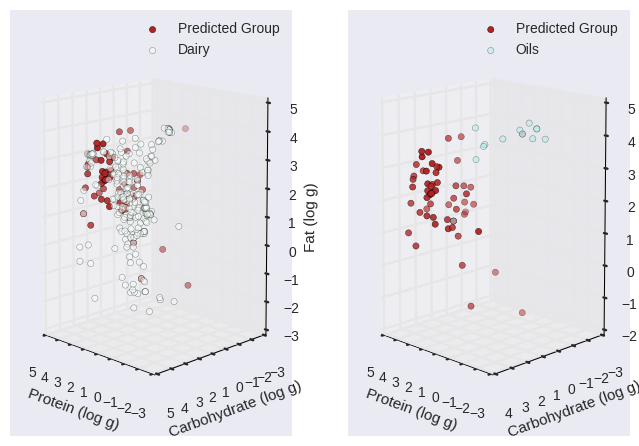

In [103]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled2, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled2, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

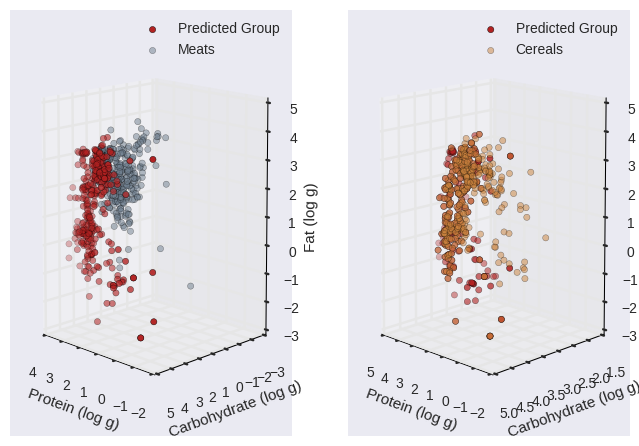

In [104]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

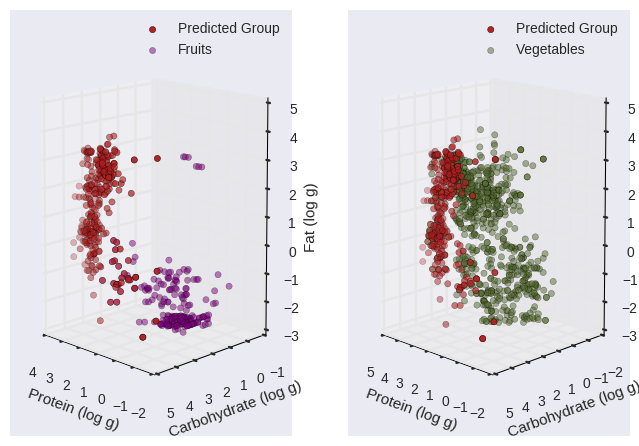

In [105]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

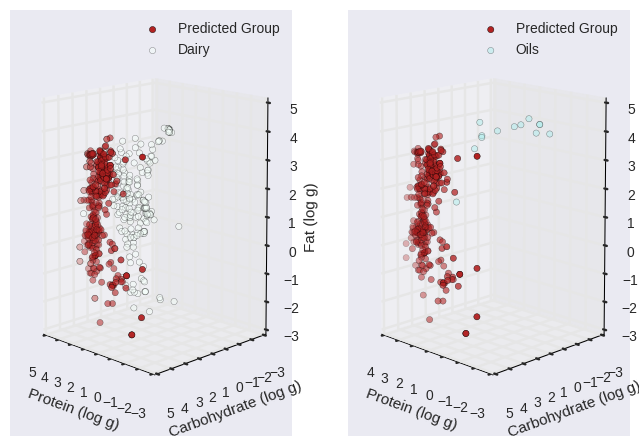

In [106]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled3, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled3, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

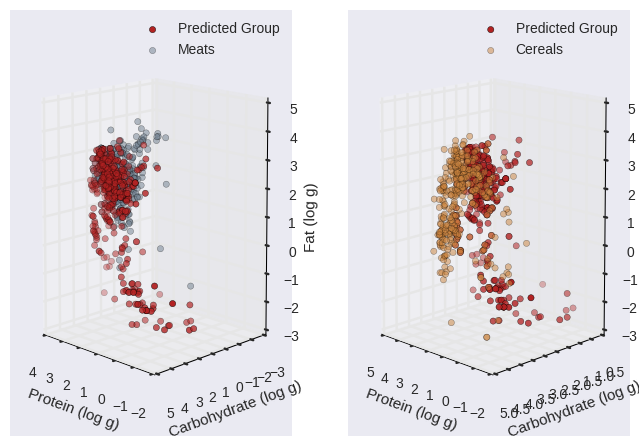

In [107]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

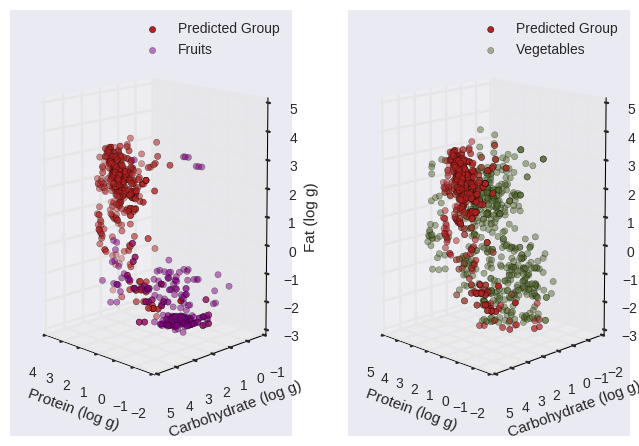

In [108]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

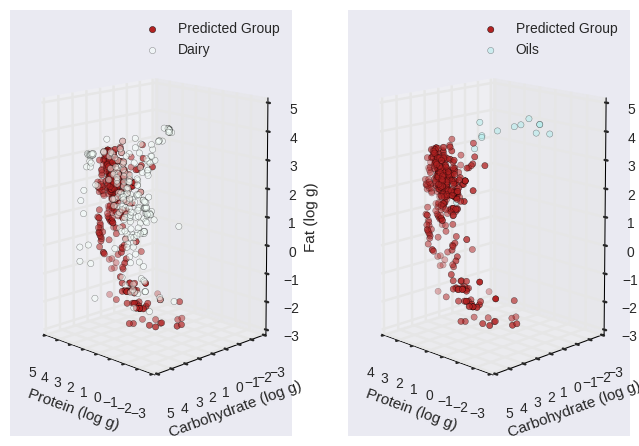

In [109]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled4, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled4, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()

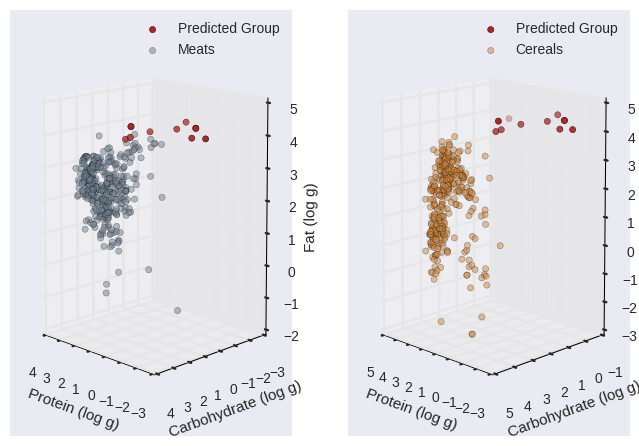

In [110]:
ax0 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, meats, ax0, 'Meats', ['firebrick','slategray'])

ax1 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, cereals, ax1, 'Cereals', ['firebrick','peru'])

plt.legend()

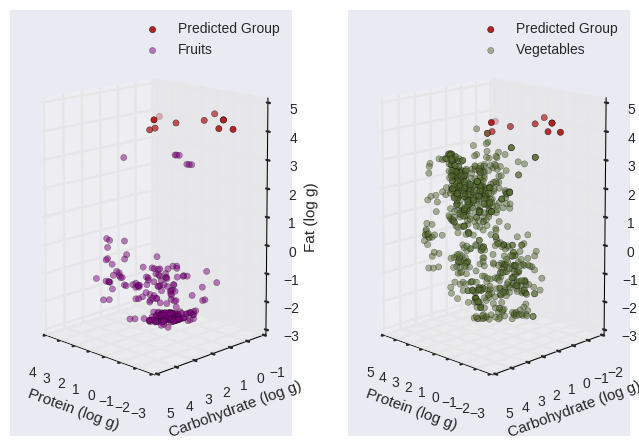

In [111]:
ax2 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, fruits, ax2, 'Fruits', ['firebrick','purple'])

ax3 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, veggies, ax3, 'Vegetables', ['firebrick','darkolivegreen'])
plt.legend()

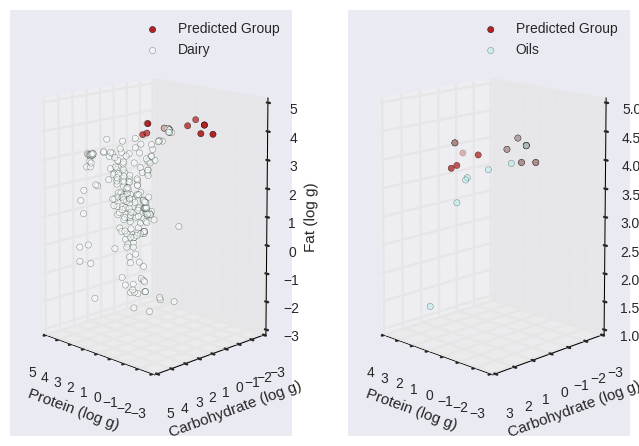

In [112]:
ax4 = plt.subplot(121, projection='3d')
ThreeDPlot(labeled5, dairy, ax4, 'Dairy', ['firebrick','mintcream'])

ax5 = plt.subplot(122, projection='3d')
ThreeDPlot(labeled5, oils, ax5, 'Oils', ['firebrick','paleturquoise'])
plt.legend()